![logo](../../../LogoLine_horizon_C3S.png)

# Satellite fire burned area completeness for seasonal climatology maps 

Production date: 25/06/2024

Produced by: Rita Cunha (CoLAB +ATLANTIC)

## 🌍 Use case: Identification of fire-prone areas for monitoring and prevention

## ❓ Quality assessment question
* **How well can we disclose what are the spatial patterns of the total burned area per season over the Iberian Peninsula?**

In this Use Case we will access the Fire burned area from 2001 to present derived from satellite observations (henceforth, FIRE) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S) and analyse the spatial patterns of the FIRE reliability over a given Area of Interest (AoI), considering the Nomenclature of Territorial Units for Statistics, at the level 2, which are used for decision monitoring and decision-making purposes (see section 3)’

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
* The dataset accurately reflects the burned area values observed during significant fire events, such as the summer of 2003 in Portugal, with a high level of precision. The burned area recorded (more than 3500 km² in Centro PT and Alentejo regions) is consintent with the Portuguese national statistics and findings by Lourenço and Luciano (2018). This consistency suggests that the dataset accurately represents extreme fire events.

* The results of this notebook shows that the spatial resolution is sufficient to detect regional differences in burned area, and the temporal resolution is adequate to highlight annual and seasonal variations, ensuring a comprehensive understanding of fire patterns over time.

* The stability of the dataset is evidenced by its consistency with other credible sources, such as Grünig et al., 2023, which supports the findings of significant burned areas in key regions during specific years. The dataset reliably identifies both extreme fire events and regions with consistently low burned areas, such as La Rioja and Murcia.

```{figure} b0838746-6694-43a3-8244-486eb1346215.png
---
height: 500px
---
The figure shows the regional climatology of the burned area over the period 2001 to 2019. The averaged burned area, and corresponding spatial pattern, can serve as a baseline for wildfire prevention and monitoring.
```

## 📋 Methodology

[](satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-1) 

[](satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-2)

[](satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-3)

[](satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-4)  

- [](satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-4.1) 

- [](satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-4.2)
    
- [](satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-4.3)

[](satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-5) 


## 📈 Analysis and results

(satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-1)=
### 1. Define the AoI, search and download FIRE dataset
Before we begin, we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS and importing the various python libraries that we will need.

#### Install CDS API
To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).
If you already have the CDS API installed, you can skip or comment this step.

In [ ]:
!pip install cdsapi

#### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import regionmask
import shapely
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

#### Data overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu Here you can search for 'Satellite observations' data using the search bar. The data we need for this tutorial is the Fire burned area from 2001 to present derived from satellite observations. This data provides global (at grid scale) and continents (at pixel scale) information of total burned area (BA), following the Global Climate Observing System (GCOS) convention. The dataset is provided with a high spatial resolution, through the analysis of reflectance changes from medium resolution sensors (Terra MODIS, Sentinel-3 OLCI) supported by thermal information.

The BA is identified by the date of the first detection of the burned signal in the case of the pixel product, and by the total BA per grid cell in the case of the grid product. Information such as land cover class, confidence level or standard error are also provided.

The temporal resolution varies per version, from 15 days (at grid scale) to monthly (at pixel scale), and its vertical resolution corresponds to the surface (single level).

Different versions are available, offering the first global BA time series at 250 m resolution (FireCCI v5.0cds and FireCCI v5.1cds developed as part of the Fire ECV Climate Change Initiative Project (Fire CCI)). This algorithm was adapted to Sentinel-3 OLCI data to create the C3S v1.0 burned area product, extending the BA database to the present.

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. In this Use case, we will retrieve information of the grid ESA-CCI version. These can all be selected in the “Download data” tab from the CDS. In this tab a form appears in which we will select the following parameters to download, for example:

- Origin: ESA-CCI
- Sensor: MODIS
- Variable: Grid
- Version: 5.1.1cds
- Region: all
- Year: 2001 to 2019
- Month: all
- Nominal day: 01
- Format: Zip file (.zip)

At the end of the download form, select `Show API request`. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook.

Having copied the API request to a Jupyter Notebook cell, running it will retrieve and download the data you requested into your local directory. However, before you run it, the terms and conditions of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the `Show API request` option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

In [38]:
# Time period
year_start = 2001
year_stop = 2019

# Region of interest
lon_slice = slice(-10, 4)
lat_slice = slice(45, 36)

# Shapefile with regions
shapefile_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip"

In [39]:
# Define request
request = (
    "satellite-fire-burned-area",
    {
        "format": "zip",
        "origin": "esa_cci",
        "sensor": "modis",
        "version": "5_1_1cds",
        "year": [str(year) for year in range(year_start, year_stop + 1)],
        "variable": "grid_variables",
        "month": ["06", "07", "08"],
        "nominal_day": "01",
    },
)

In [ ]:
# Download and regionalize
ds = download.download_and_transform(
    *request,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    chunks={"year": 1},
)

# Reindex using year/month (shift months + 1)
ds = ds.assign_coords(
    year=("time", ds["time"].dt.year.astype(int).values),
    month=("time", ds["time"].dt.month.astype(int).values + 1),
)
ds = ds.set_index(time=("year", "month")).unstack("time")

# Convert units from m2 to km2
da = ds["burned_area"]
with xr.set_options(keep_attrs=True):
    da *= 1.0e-6 # Conversion factor
da.attrs["units"] = "km2"

(satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-2)=
### 2. Inspect and view data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an xarray.Dataset.

Let's inspect the years to see which have the highest and the lowest values of burned area.

In [ ]:
'hide-input'

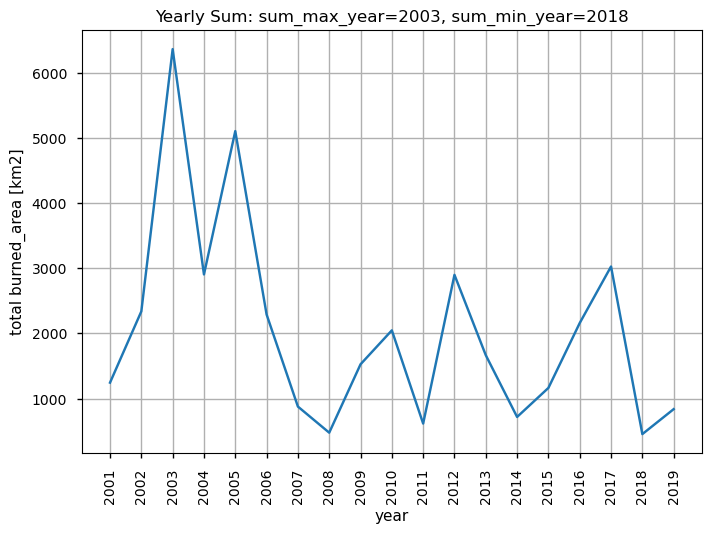

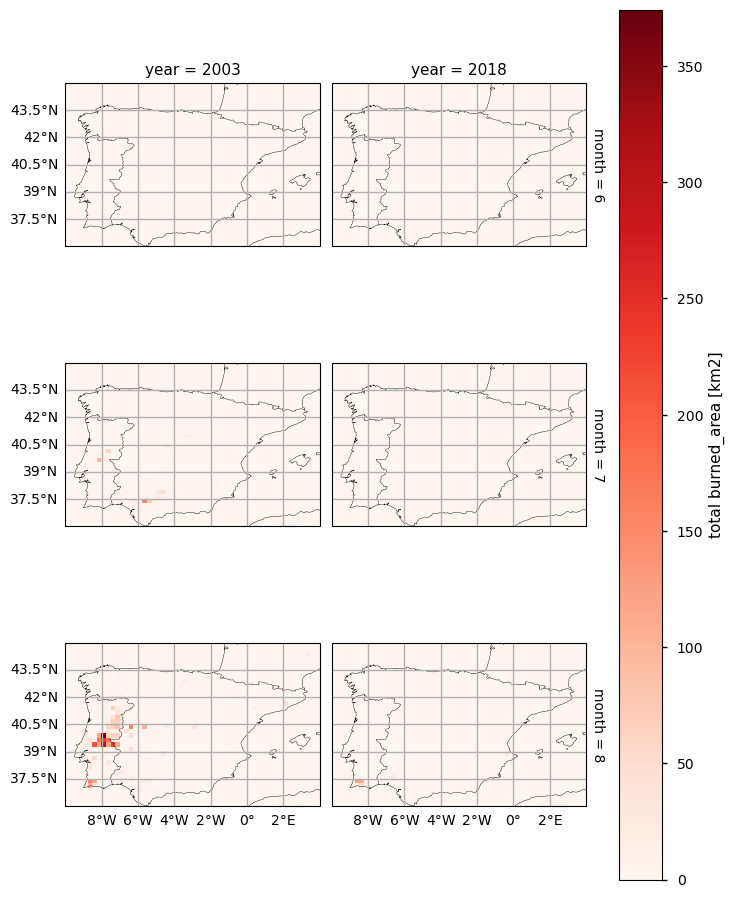

In [41]:
# Plot BA time series
da_sum = da.sum(set(da.dims) - {"year"}, keep_attrs=True)
sum_max_year = int(da_sum.idxmax("year").values)
sum_min_year = int(da_sum.idxmin("year").values)
da_sum.plot(xticks=da["year"])
plt.xticks(rotation=90)
plt.grid()
plt.title(f"Yearly Sum: {sum_max_year=}, {sum_min_year=}")

facet = plot.projected_map(
    da.sel(year=[sum_max_year, sum_min_year]),
    plot_func="imshow",
    col="year",
    row="month",
    cmap="Reds",
    projection=ccrs.PlateCarree(),
)
for ax in facet.axs.flatten():
    ax.add_feature(cfeature.BORDERS)

From these statistics and the corresponding maps, we can conclude that 2003 and 2018 have the highest and the lowest sum burned area values (respectively). We can also see some hotspot regions in the centre of Portugal in August.

(satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-3)=
### 3. Define the unit of analysis: Nomenclature of territorial units for statistics, level 2 (NUTS 2)

The [NUTS](https://ec.europa.eu/eurostat/web/nuts) are a hierarchical system divided into 3 levels. NUTS 1 correspond to major socio-economic regions, NUTS 2 correspond to basic regions for the application of regional policies, and NUTS 3 correspond to small regions for specific diagnoses. Additionally, a NUTS 0 level, usually co-incident with national boundaries is also available. The NUTS legislation is periodically amended; therefore multiple years are available for download. 

In this user question, it is used the most updated version of the NUTS corresponding to version of 2021. In this study case, NUTS 2 will be used, providing the information regarding the main regions/parcels of the Iberian Peninsula.

Note: The sum of burned area and the climatology are calculated per each NUTS 2 region. Generated maps, bar charts and plots will take some minutes to process all the months, years and regions. 

In [42]:
# Merging BA with NUTS 2 geodataframe
lon_bounds = [-10.18, 1]
lat_bounds = [36.5, 43]
crs = "epsg:4326"

lon_bounds += sorted(lon_bounds, reverse=True)
lat_bounds = [lat for lat in lat_bounds for _ in range(2)]
bbox = shapely.Polygon(zip(lon_bounds, lat_bounds))

gdf = gpd.read_file(shapefile_url)
gdf = gdf[gdf["LEVL_CODE"] == 2]
gdf = gdf[gdf.intersects(bbox)]
gdf = gdf[gdf["NUTS_ID"].str.startswith(("ES", "PT"))]
gdf = gdf.to_crs(crs)

ds.rio.write_crs(crs, inplace=True)

regions = regionmask.from_geopandas(gdf, names="NUTS_NAME")
mask = regions.mask(ds["longitude"], ds["latitude"])

(satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-4)=
### 4. Annual Summaries and Summer Climatology Analysis of the Burned Area (JJA of 2001-2019)

The step below produces the Annual Summaries of BA by representing the Bar Charts and the Maps of the Sum of the Burned Area per NUTS 2, per month/year. In this case, we are analysing the Summer (JJA) months, which is when wildfires tend to be more frequent, in the Iberian Peninsula Region.

In addition, the Summer Climatology for BA aims to provide an overview of fire activity over a long-term period, such as multiple years or decades.

According to the European Environment Agency (EEA (2021) Europe's changing climate hazards — an index-based interactive EEA report, Report no. 15/2021, EEA. DOI: 10.2800/458052) methodology, the following steps are conducted:
- the sum of Burned Area is calculated for each year within the defined period; 
- the resulting timeseries is average across the number of years. 

This average BA represents the typical magnitude of burned areas during the summer period (June, July and August, from 2001 to 2019).

The Annual Summaries and Summer Climatology are represented in several ways, such as maps, bar charts and timeseries plots.

(satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-4.1)=
#### 4.1. Annual Summaries - Maps and Bar Charts of total Burned Area for the summer season, per NUTS regions per year

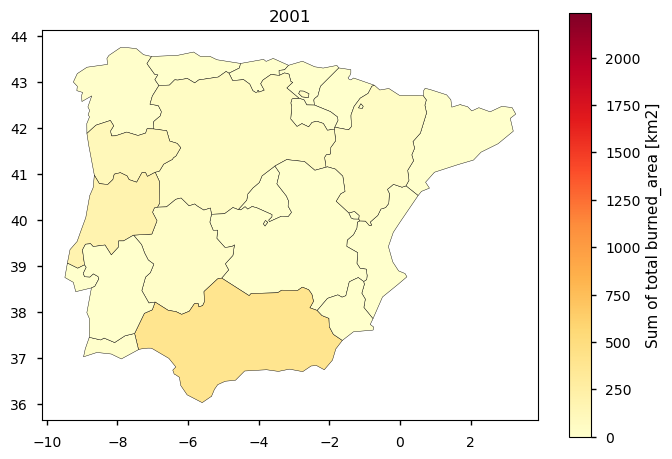

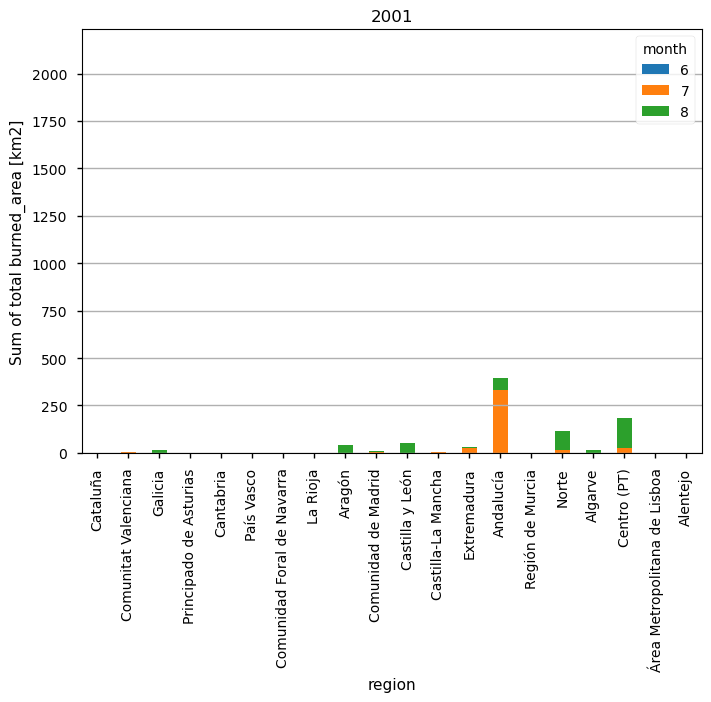

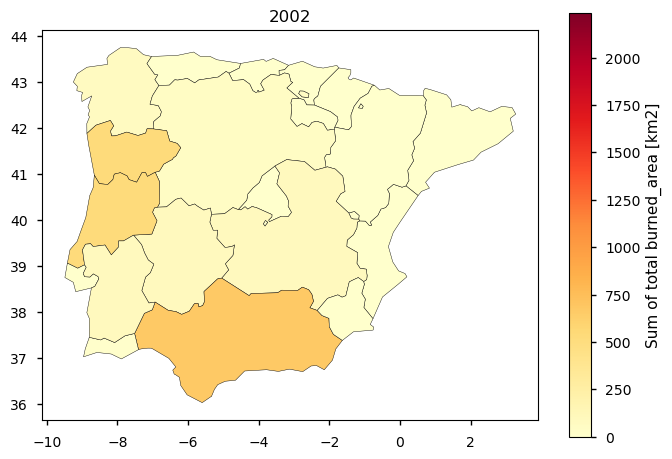

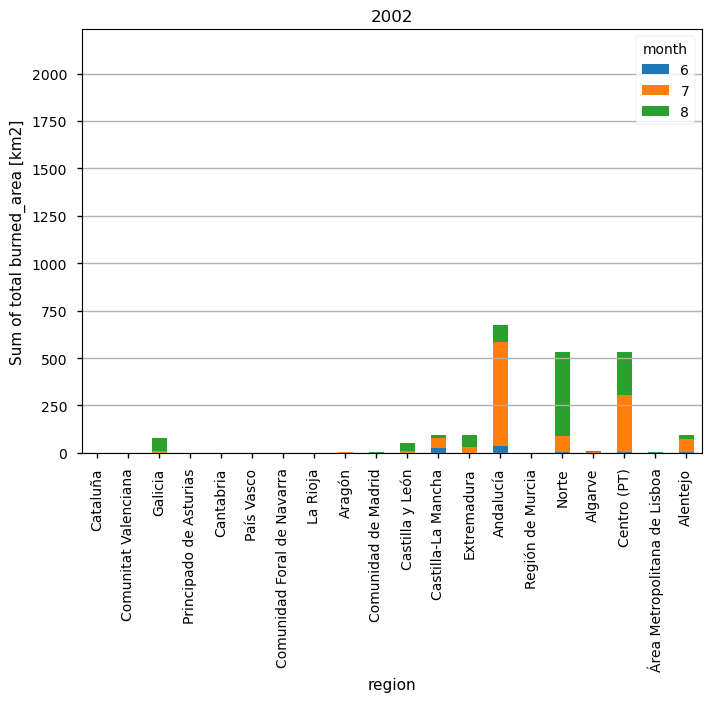

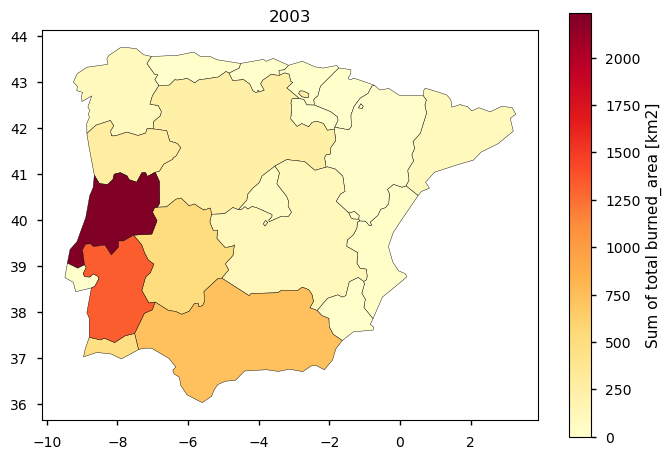

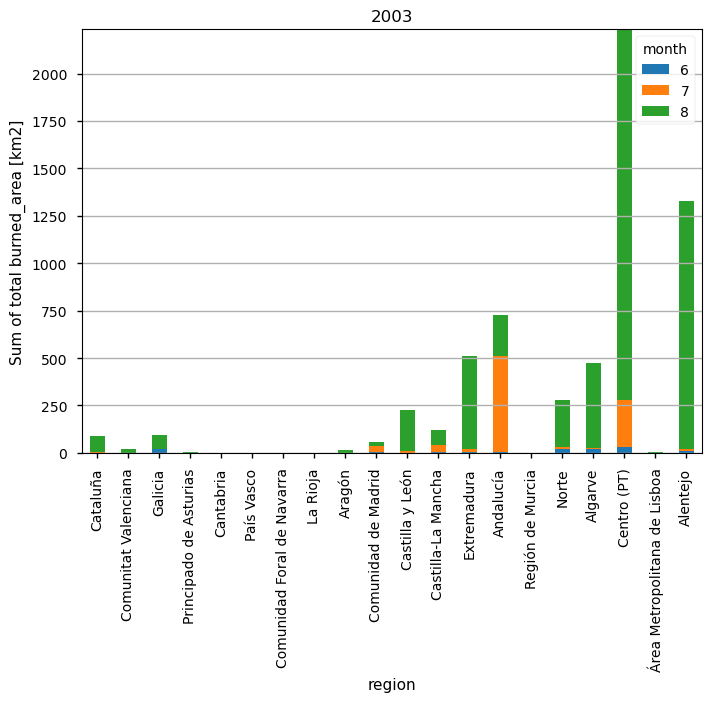

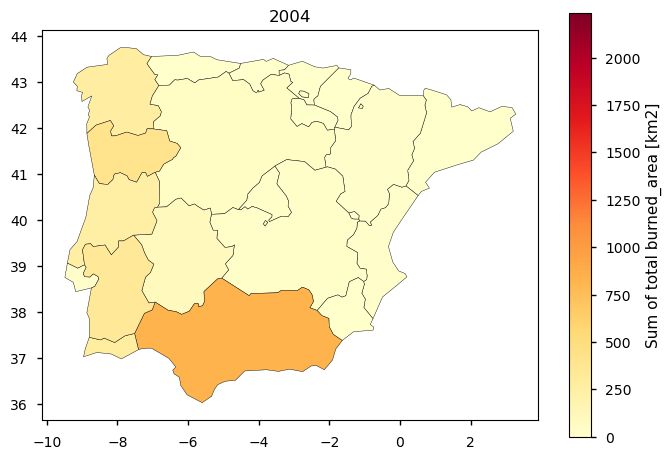

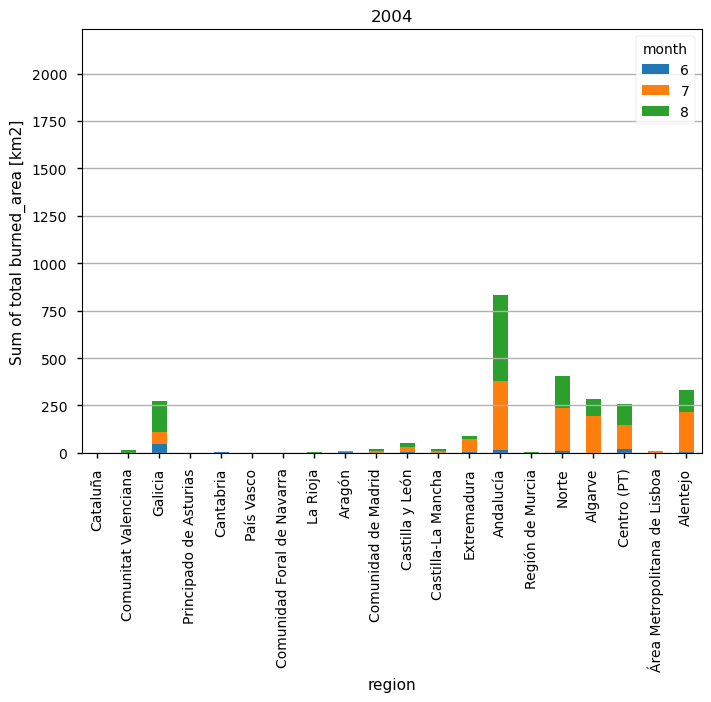

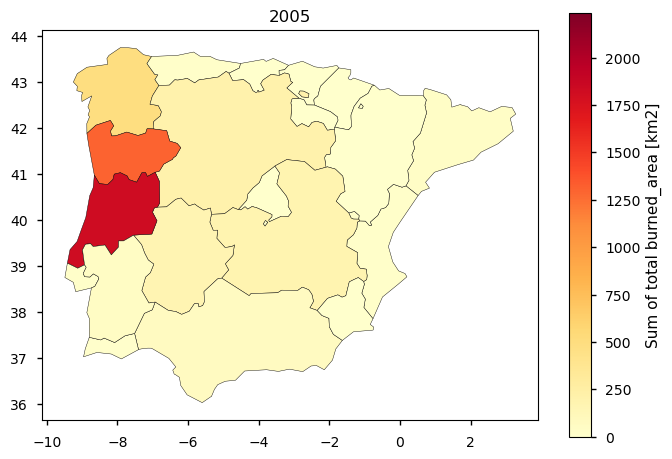

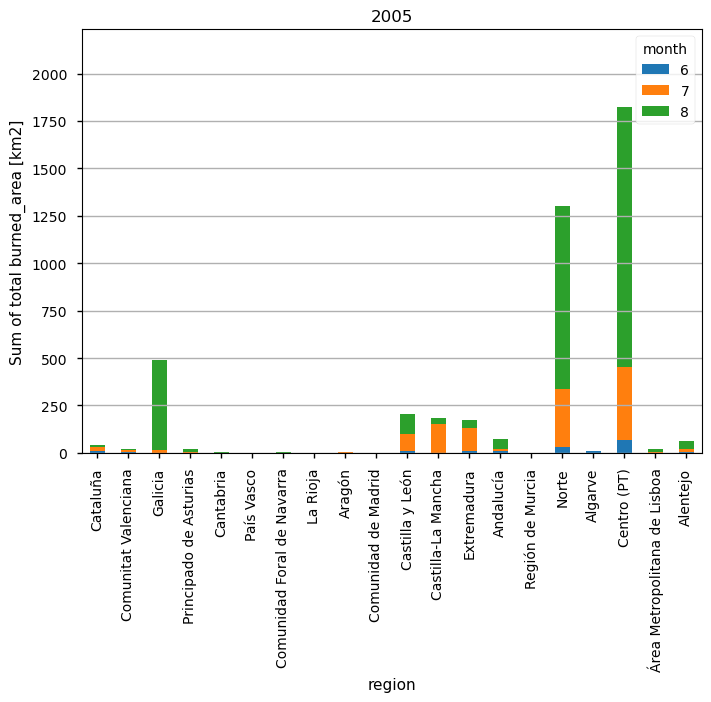

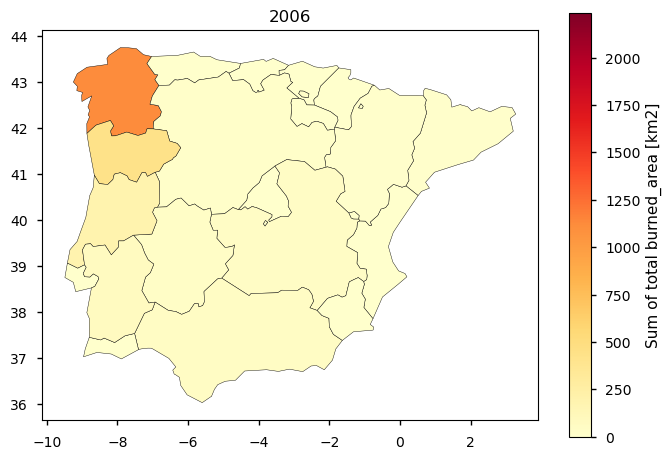

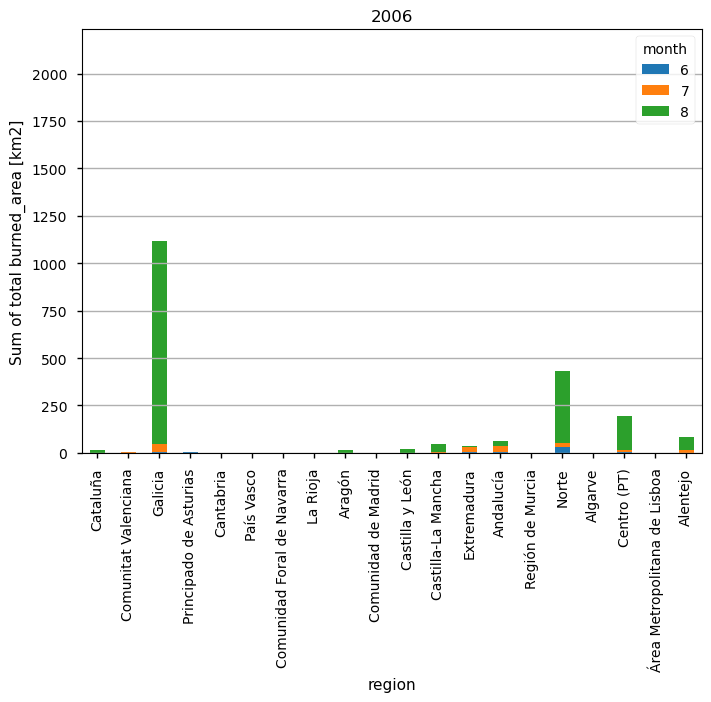

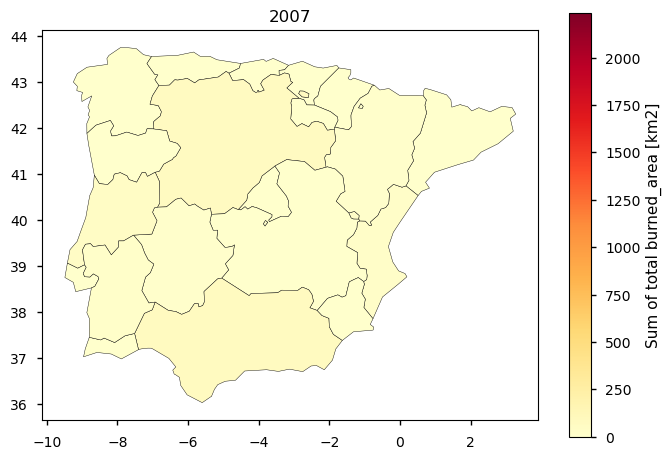

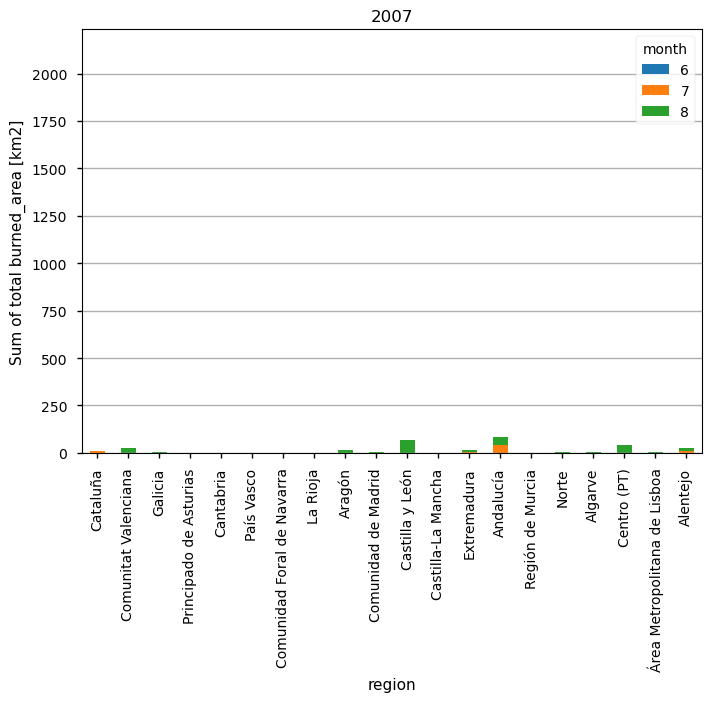

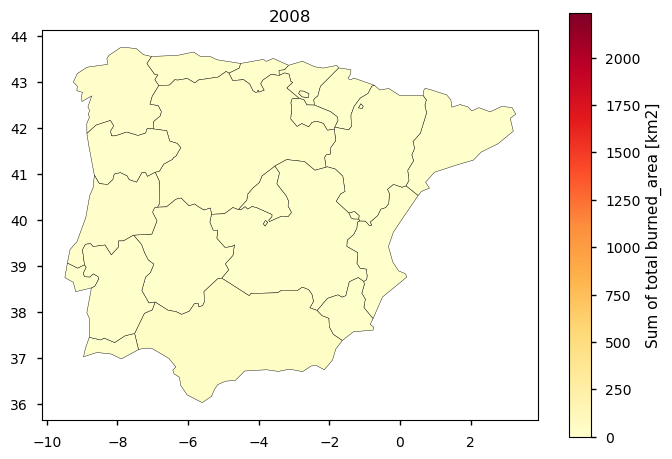

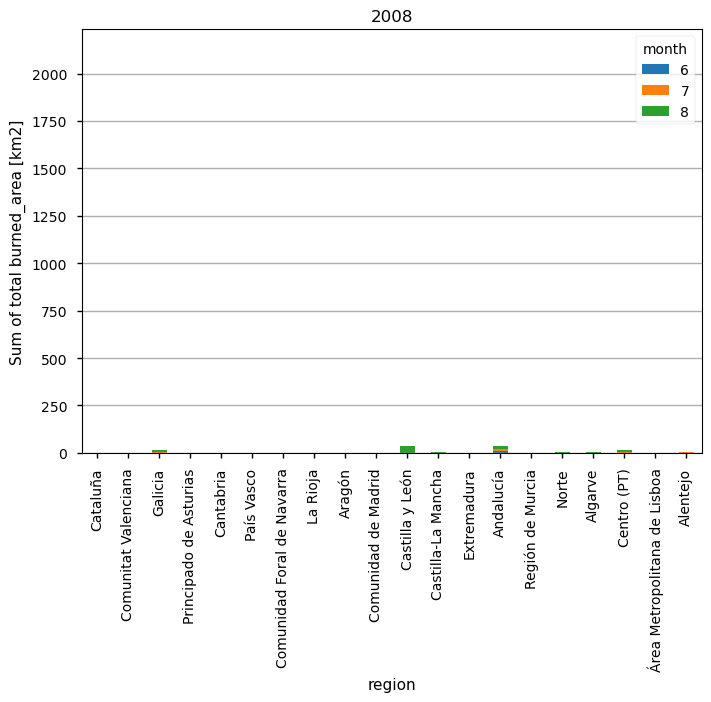

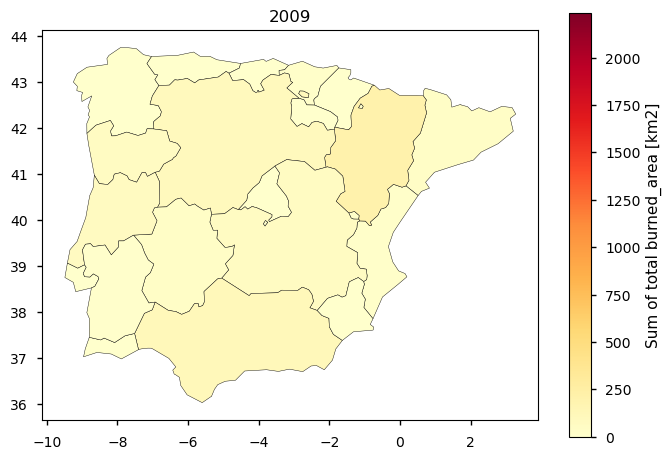

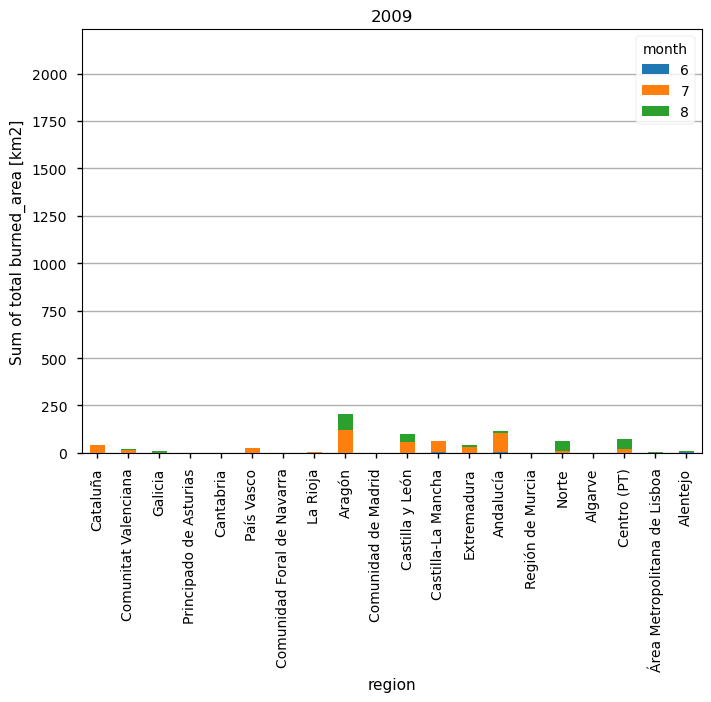

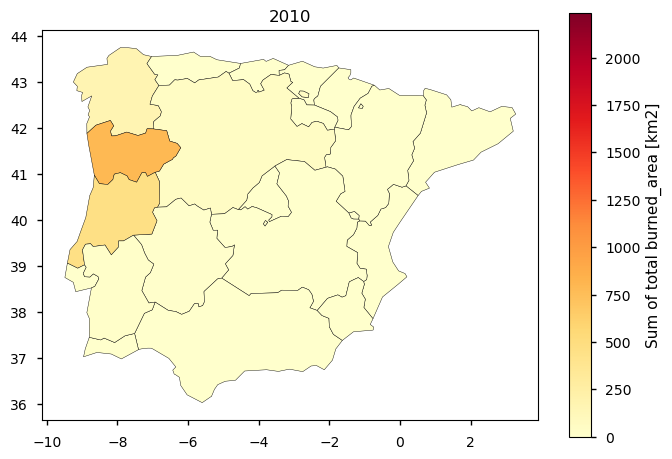

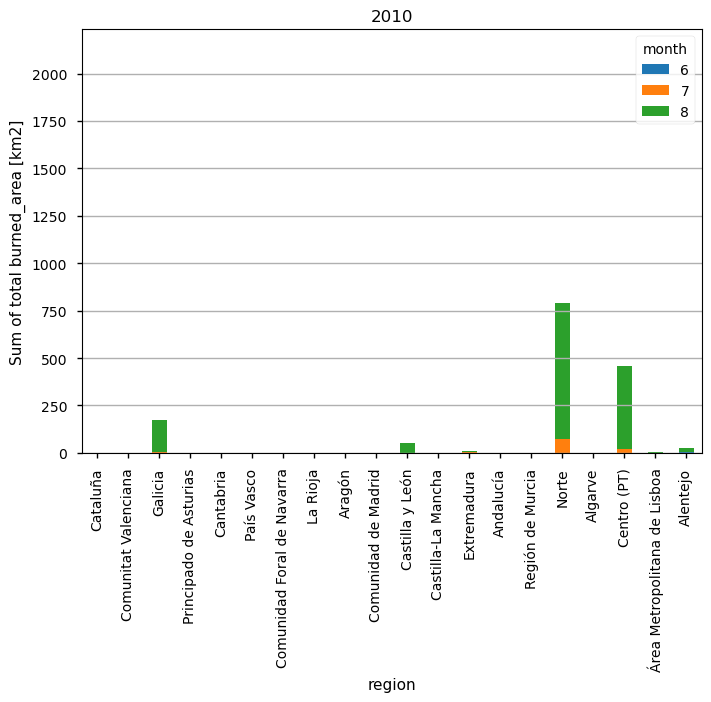

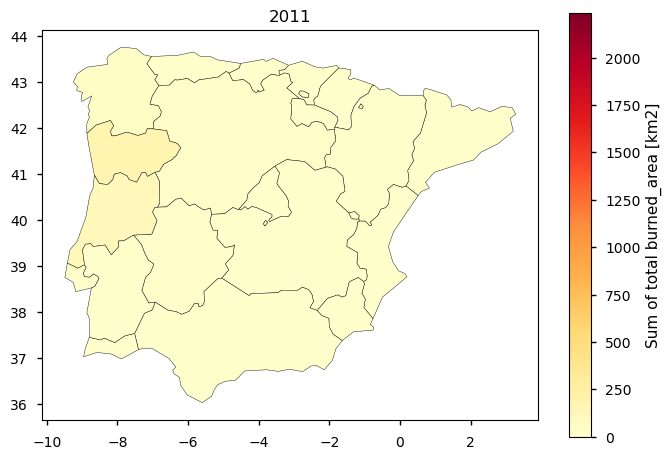

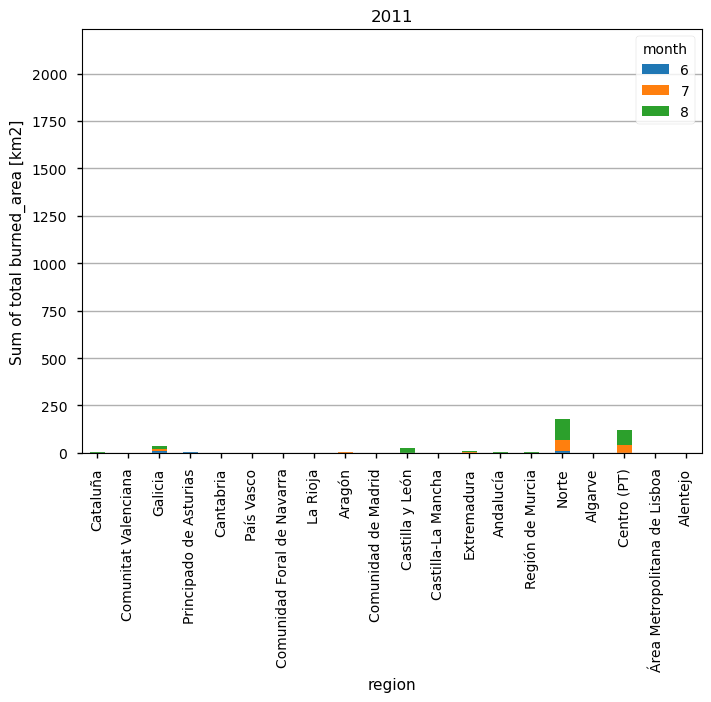

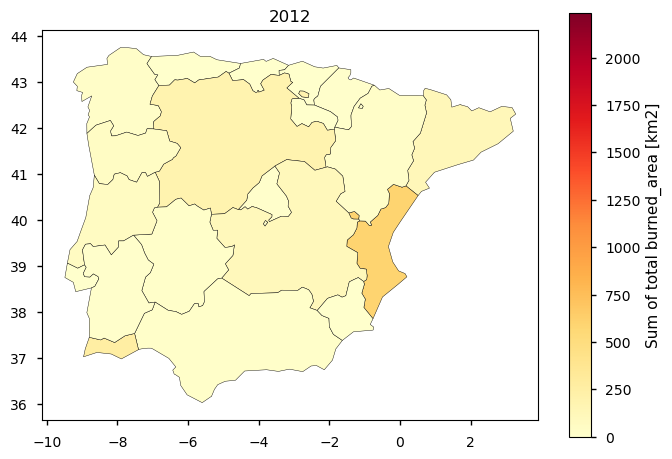

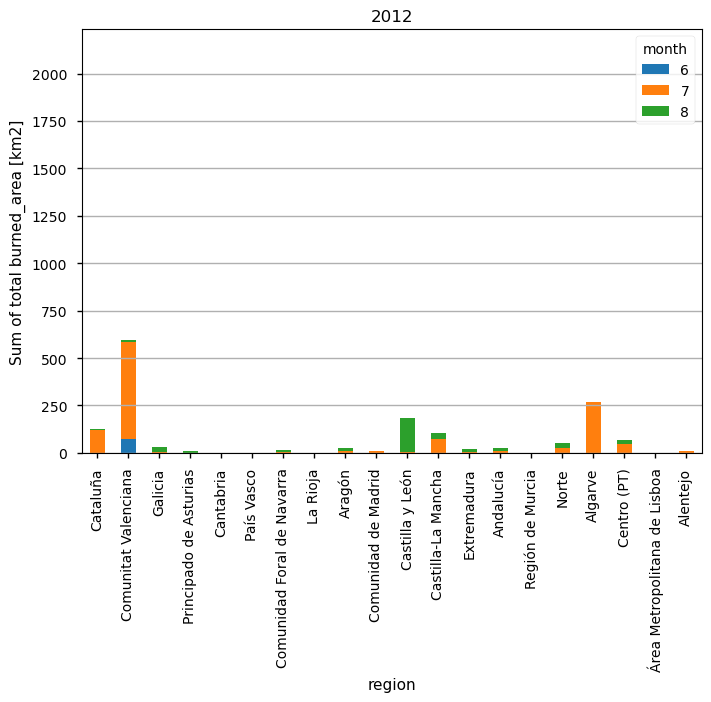

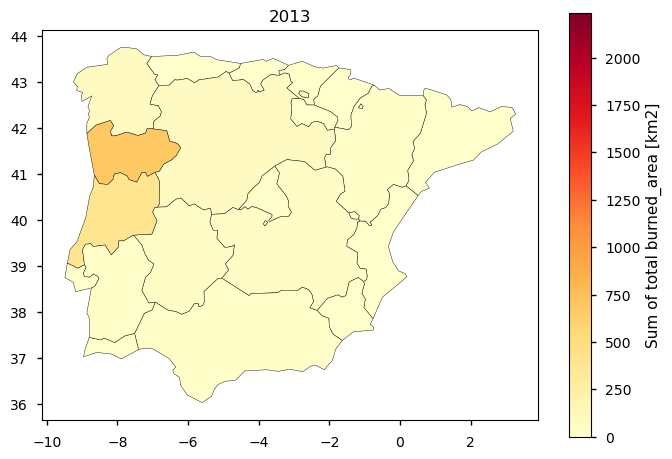

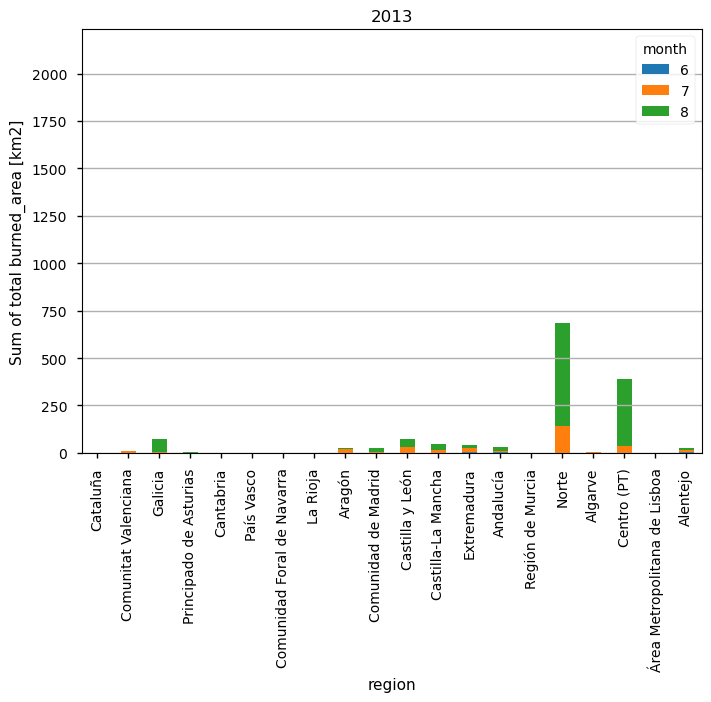

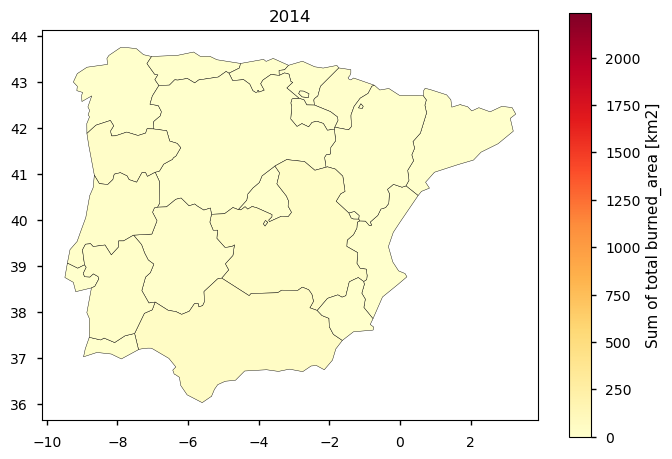

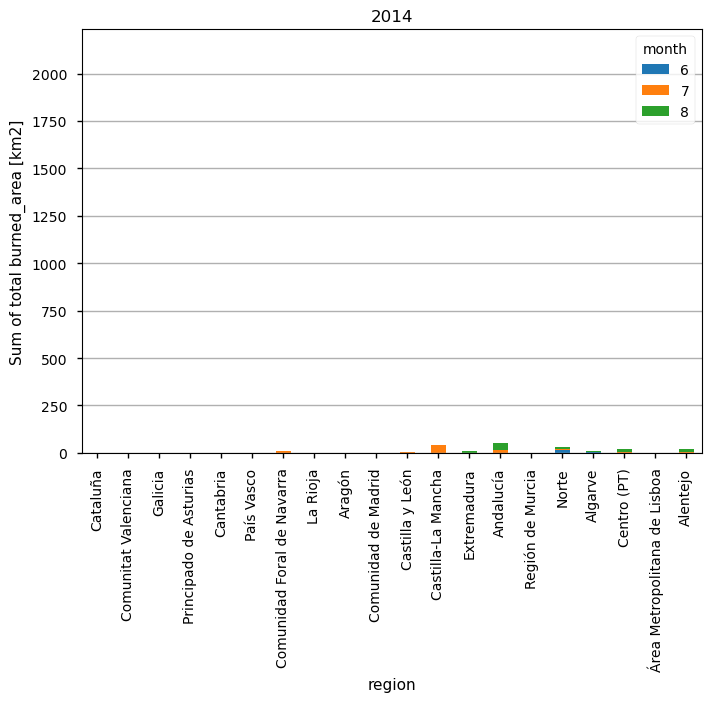

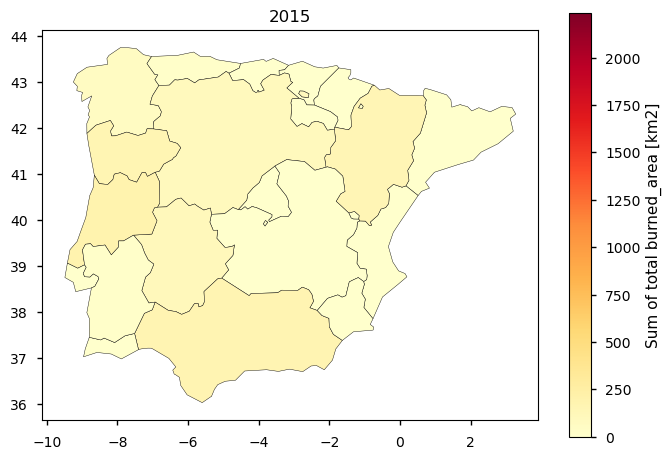

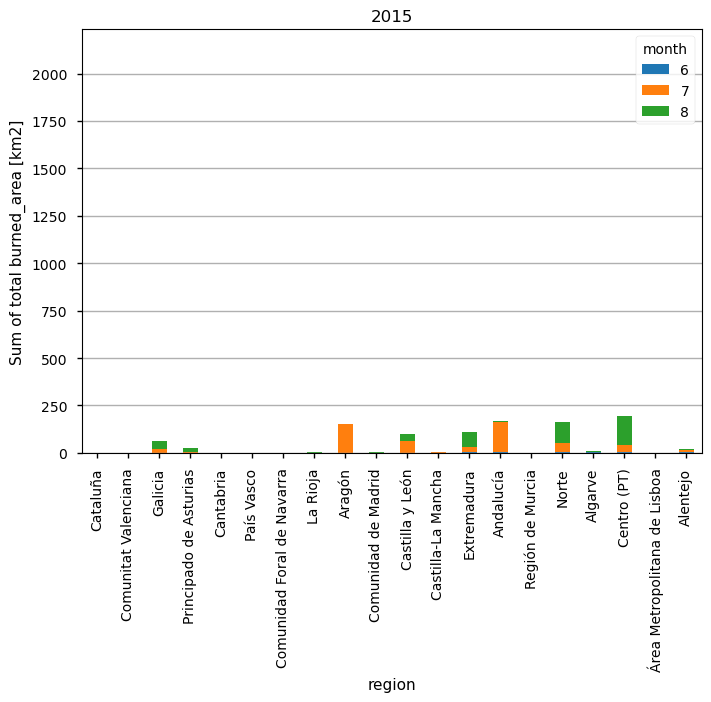

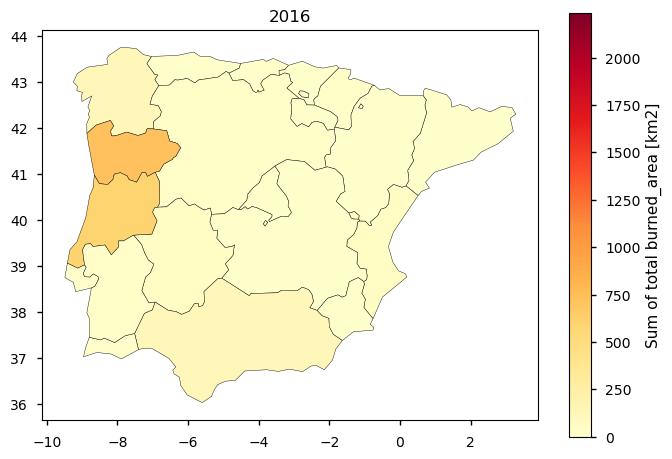

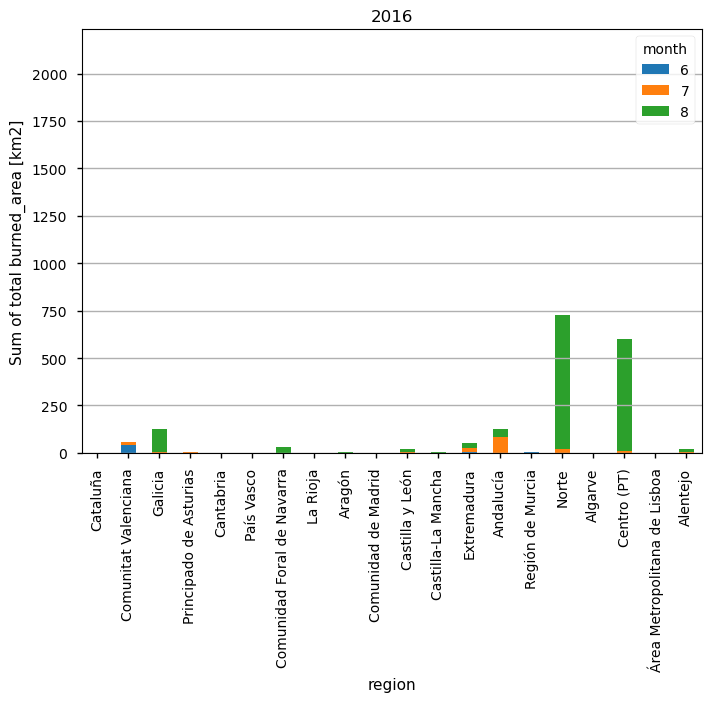

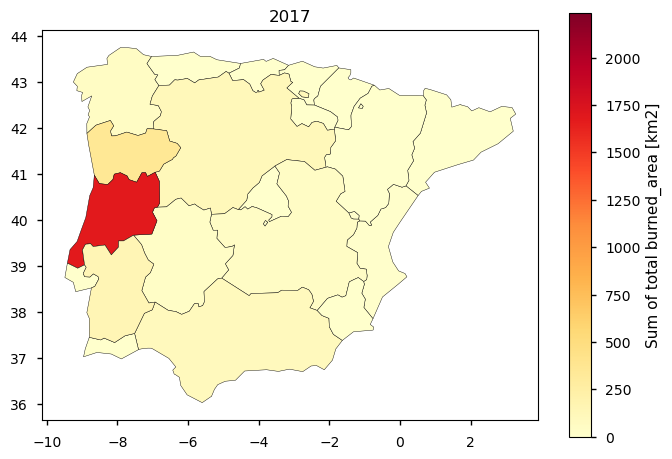

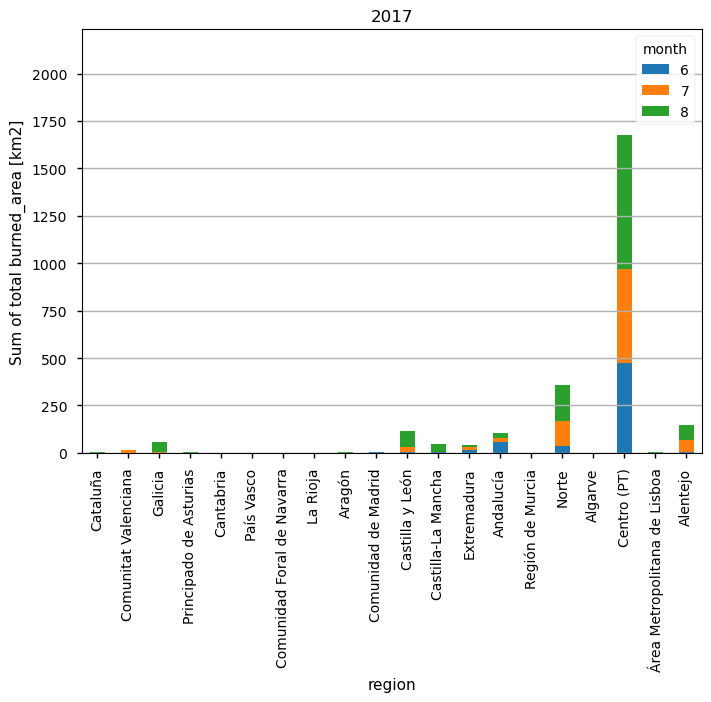

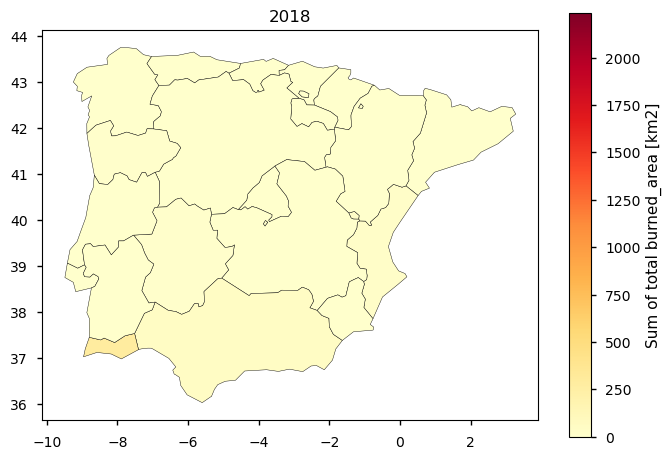

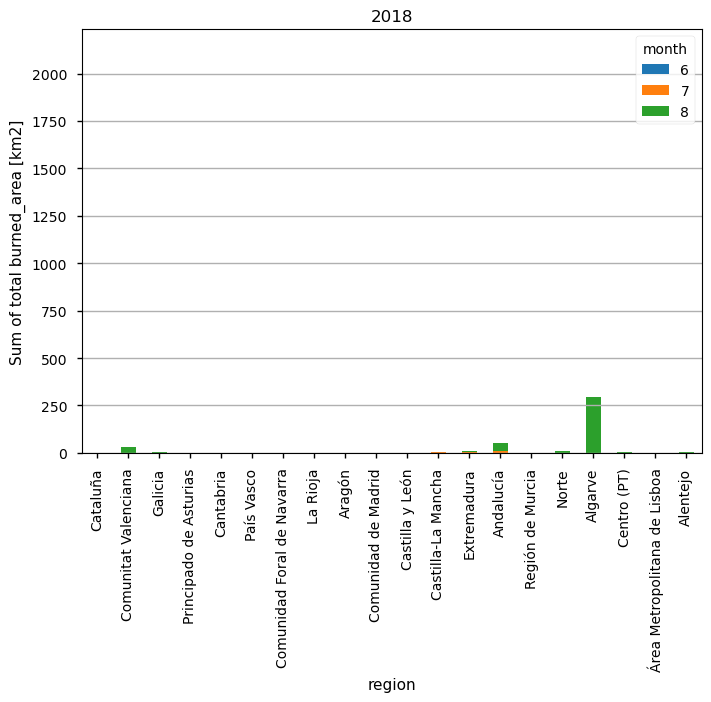

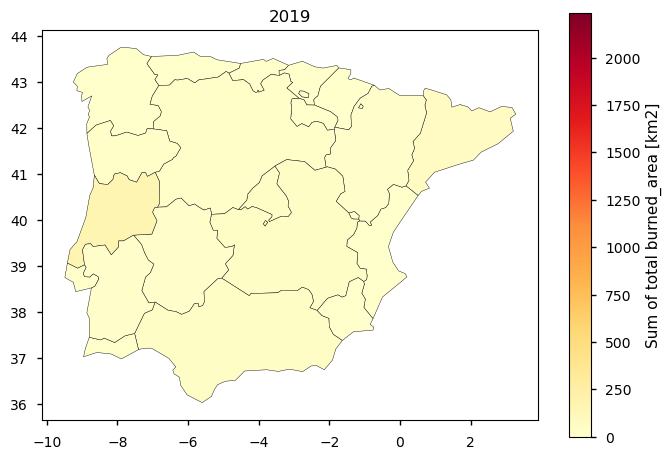

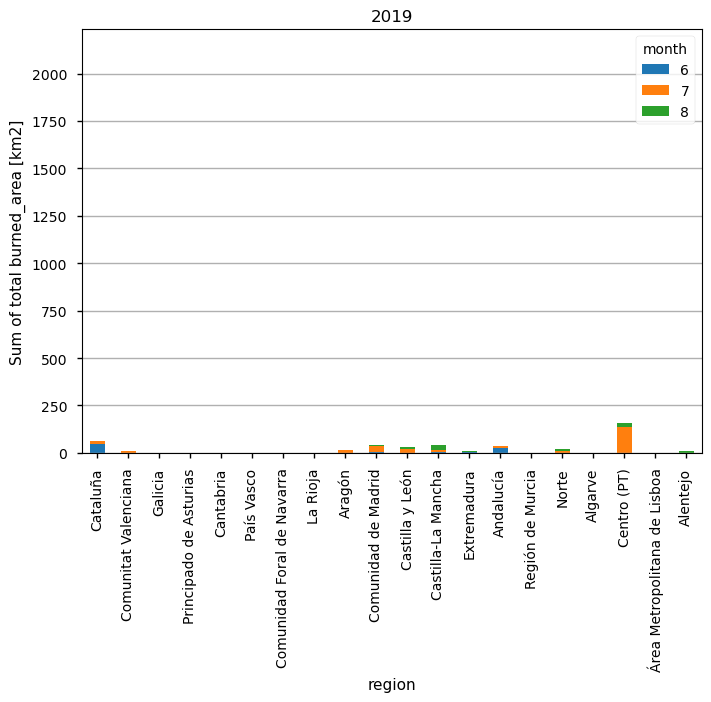

In [44]:
# Ploting maps and bar charts of annual BA by NUTS 2 region, considering the Summer season
da_grouped = da.groupby(mask.rename("region")).sum(("latitude", "longitude"))
da_grouped = da_grouped.assign_coords(region=regions.names)
ylim = (0, da_grouped.sum("month").max().values)
ylabel = f"Sum of {da.attrs['long_name']} [{da.attrs['units']}]"
for year, da_grouped_year in da_grouped.groupby("year"):
    df = da_grouped_year.to_pandas()
    ax = gdf.plot(
        df.sum().values,
        cmap="YlOrRd",
        vmin=ylim[0],
        vmax=ylim[-1],
        edgecolor="k",
        legend=True,
        legend_kwds={"label": ylabel},
    )
    ax.set_title(year)
    plt.show()

    ax = df.T.plot.bar(
        title=year,
        ylabel=ylabel,
        stacked=True,
        ylim=ylim,
    )
    ax.grid(axis="y")
    plt.show()

From the above set of plots, we can already distinguish certain years and areas more prone to extreme wildfire events. To better analyse its temporal pattern, let's plot the annual sum as a time series plot - this plot is equivalent to the first one in this notebook, but now we have added the NUTS 2 regions to facilitate our understanding of which regions have greater BA and in which years.

(satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-4.2)=
#### 4.2. Annual Summaries - Timeseries of total Burned Area for the summer season, per NUTS regions per year

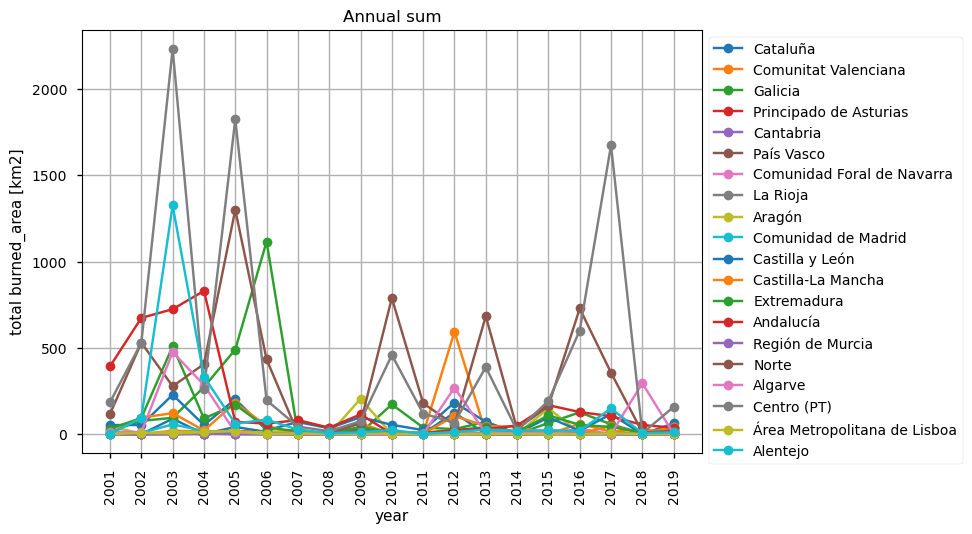

In [45]:
# Ploting annual timeseries of BA by NUTS 2 regions, considering the Summer season
da_grouped_yearly = da_grouped.sum("month", keep_attrs=True)
lines = da_grouped_yearly.plot(
    hue="region", marker="o", xticks=da["year"], add_legend=False
)
_ = plt.legend(lines, da_grouped["region"].values, bbox_to_anchor=(1, 1))
_ = plt.xticks(rotation=90)
_ = plt.title("Annual sum")
_ = plt.grid()

Having looked into this time series, we can clearly see that the highest BA values are reached in certain regions, such as 'Centro (PT)', 'Alentejo' or 'Norte', in Portugal, or 'Andalucía' and 'Extremadura', in Spain. However, we can also see that there is no indication of an increase in BA, in recent years. Now let's plot the time series per region to see this in more detail. We will also use a colour code for month to highlight which are characterized by higher BA values.

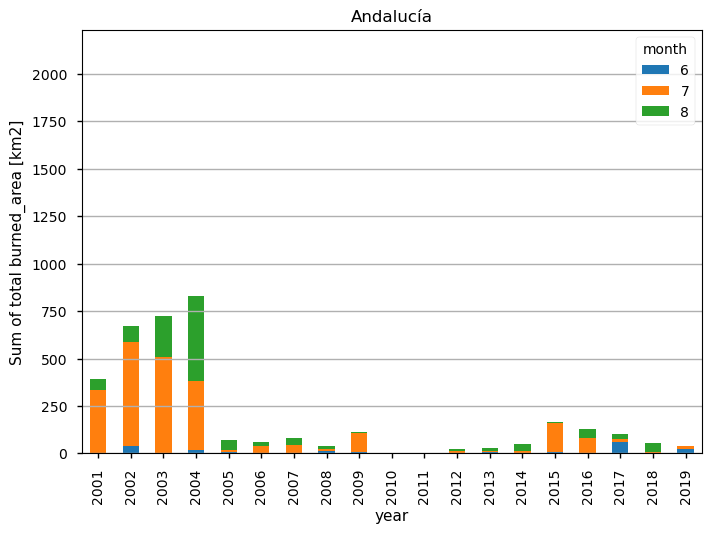

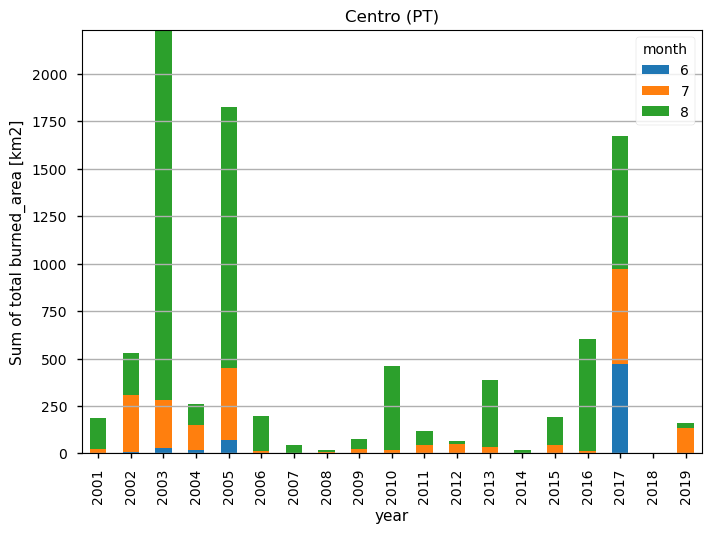

In [46]:
# List of regions with higher BA
regions_to_plot = ["Andalucía", "Centro (PT)"]

# Ploting annual timeseries of BA by NUTS 2 regions and months, considering the Summer season
for region, da_grouped_region in da_grouped.groupby("region"):
    if region in regions_to_plot:
        df = da_grouped_region.squeeze().to_pandas()
        ax = df.plot.bar(
            title=region,
            ylabel=ylabel,
            stacked=True,
            ylim=ylim,
        )
        ax.grid(axis="y")
        plt.show()
        # print(region)

From these plots, we can now confirm that the month of August is when more BA is detected in the product, which agrees with the known climate seasonality of the region. We will now compute the climatology per season to see typical spatial patterns of the fire BA, together with a bar chart with climate BA values per NUTS 2.

(satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-4.3)=
#### 4.3. Seasonal Climatology (2001-2019) - Map and Bar Chart of the average total Burned Area for the summer season, per NUTS regions

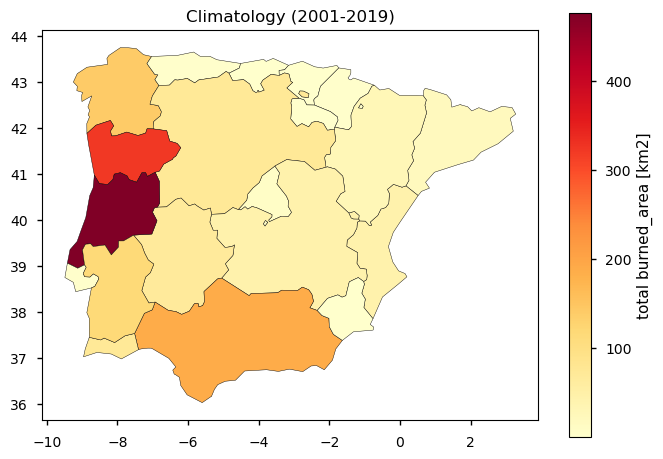

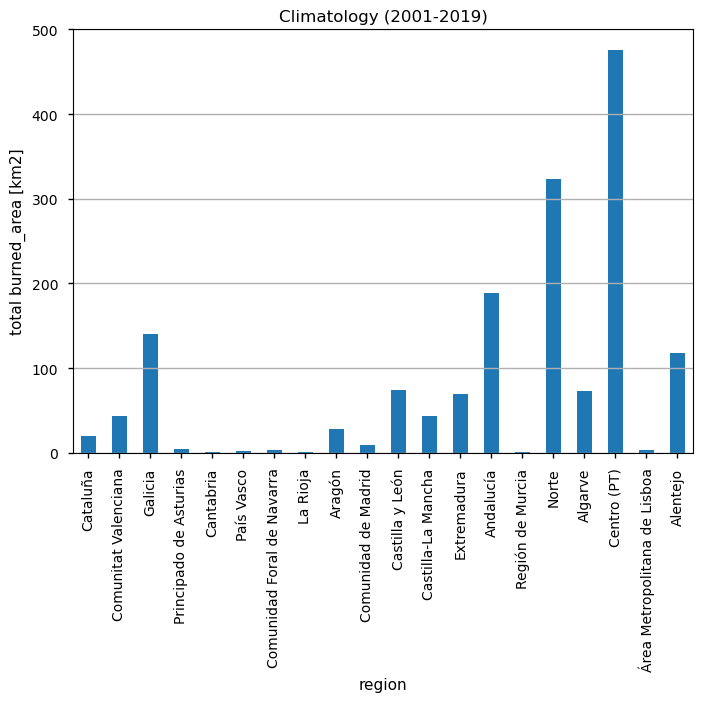

In [47]:
da_climatology = da_grouped_yearly.mean("year")
ylabel = f"{da.attrs['long_name']} [{da.attrs['units']}]"
title = f"Climatology ({year_start}-{year_stop})"
ax = gdf.plot(
    da_climatology.values,
    cmap="YlOrRd",
    edgecolor="k",
    legend=True,
    legend_kwds={"label": ylabel},
)
ax.set_title(title)
plt.show()

ax = da_climatology.to_pandas().plot.bar(ylabel=ylabel)
_ = ax.set_title(title)
_ = ax.grid(axis="y")

With this final plot we can see what the average BA is, and the corresponding spatial pattern, to serve as a baseline for wildfire prevention and monitoring.

(satellite_satellite-fire-burned-area_climate-and-weather-extremes_q01:code-section-5)=
### 5. Main takeaways

- In particular, during the summer of 2003 the highest value of burned area is observed in Portugal (more specifically, in Centro PT and Alentejo regions), accounting for more than 3500 km², which agrees with known extreme values of burned area occurring in that year (as per the Portuguese national statistics on burned area, available at www.pordata.pt). This results also are consisten with, [Lourenço and Luciano (2018)](https://doi.org/10.4000/MEDITERRANEE.9958), which recorded a burned area for Portugal with values similar with this analysis (more that 4000 km² of burned area); hence, the results presented in this study show that the dataset depicts, in a very clear way, the events described.

- Considering the Annual Summary analysis for the NUTS 2 regions, it can be concluded that Centro PT, Alentejo, Norte, Andalucía and Galicia are the regions that registered the highest values of burned area (this statement it is supported by the study of [Grünig et. al., 2023](https://doi.org/10.1111/GCB.16547), which found a largest average maximum fire size recorded for Portugal and highest average maximum burn severity for Spain), during the Summer months (JJA), from 2001 to 2019 - 2233 km²(2003, in Centro PT, Portugal), 1326 km² (2003, in Alentejo, Portugal), 1301 km² (2005, in Norte, Portugal), 840 km² (2004, in Andalucía, Spain), and 1117 km² (2006, in Galicia, Spain).

- By contrast, several regions show consistently absence or very low values of burned area for the same time period - e.g., La Rioja only had a total of 9 km² of burned area occuring in only 4 out of the 19 years; equivalent pattern can be described for the Region of Murcia, which only had a total of 11 km² of burned area occurring in only 5 out of the 19 years.

## ℹ️ If you want to know more

### Key resources

Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used were:

* Fire burned area from 2001 to present derived from satellite observations:

  https://cds.climate.copernicus.eu/datasets/satellite-fire-burned-area?tab=overview

EEA FIRE Climatology Methodology:
* https://www.eea.europa.eu/publications/europes-changing-climate-hazards-1

FIRE dataset Product User Guide (PUG):
* https://dast.copernicus-climate.eu/documents/satellite-fire-burned-area/D3.3.14-v1.0_PUGS_CDR_BA-FireCCI_MODIS_v5.1cds_PRODUCTS_v1.0.1.pdf 

Eurostat NUTS (Nomenclature of territorial units for statistics) regions and definition link:
* https://ec.europa.eu/eurostat/web/nuts 

Code library used
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)

### References


[[1]](https://doi.org/10.1007/s00704-023-04427-y) Bento, Virgílio A., Ana Russo, Inês Vieira, and Célia M. Gouveia. 2023. “Identification of Forest Vulnerability to Droughts in the Iberian Peninsula.” Theoretical and Applied Climatology 152 (1–2): 559–79. 

[[2]](https://doi.org/10.4000/MEDITERRANEE.9958) Lourenço, and Luciano. 2018. “Forest Fires in Continental PortugalResult of Profound Alterations in Society and Territorial Consequences”. Méditerranée (Online): 130 | 2018. 

[[3]](https://doi.org/10.1111/GCB.16547) Grünig, Marc, Rupert Seidl, and Cornelius Senf. 2023. “Increasing Aridity Causes Larger and More Severe Forest Fires across Europe.” Global Change Biology 29 (6): 1648–59. 